# XILLVER emulation demo

With a feed-forward neural network emulator built and trained by Maggie in Tensorflow.

`emullver.py` contains a set of helper functions for using the model <br>
`xspec_comparison` contains functions for extracting xspec spectra and plotting a comparison between the emulated and xspec spectra

### Details to note:
- The model was saved with **Keras 2.15 and TensorFlow < 2.5 --> make sure to install tensorflow 2.15**, otherwise the backwards compatibility in Keras 3 doesn't quite work 
- The model was trained on extended xillver tables with 4999 energy bins between 0.1 eV and 10^3 keV
- Data preprocessing includes a log10 operation (with 0-values filled in at a value floor) and multiplication by a factor of precisely 2.3025851

---------

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import pickle
import xspec

import emullver
import plotting
import _globals
from xspec_comparison import comparison_figure


In [8]:
from astropy.io import fits
# fits_image_filename = fits.util.get_testdata_filepath('/xillver-a-Ec4-full.fits')

hdul = fits.open('xillver-a-Ec4-full.fits')

In [9]:
hdul.info()

Filename: xillver-a-Ec4-full.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   ()      
  1  PARAMETERS    1 BinTableHDU     35   5R x 10C   [12A, J, E, E, E, E, E, E, J,    15E]   
  2  ENERGIES      1 BinTableHDU     16   4999R x 2C   [E, E]   
  3  SPECTRA       1 BinTableHDU     17   78000R x 2C   [    5E,  4999E]   


In [38]:
(hdul[3].header)

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                20016 / width of table in bytes                        
NAXIS2  =                78000 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    2 / number of fields in each row                   
TTYPE1  = 'PARAMVAL'           / label for field   1                            
TFORM1  = '    5E  '           / data format of field: 4-byte REAL              
TTYPE2  = 'INTPSPEC'           / label for field   2                            
TFORM2  = ' 4999E  '           / data format of field: 4-byte REAL              
TUNIT2  = 'photons/cm^2/s'  

In [ ]:
#2-3 senetnces backgroiund
#1 sentence matzeu wahts done
#what we've done
#and i show
#results

### Load the emulator

In [41]:
emulator = emullver.load_emulator()

### Make a prediction for the **default** set of XILLVER parameters: 
- $\Gamma=2.0$
- $A_{\rm Fe}=1.0$
- $\log(\xi)=3.1$
- $E_{\rm cut}=300$
- $i=30$

In case no emulator is provided, `emullver.emulated_spectrum` loads it automatically

In [42]:
egrid, spec = emullver.emulated_spectrum(1, 1, 1, 1, 1, emulator=emulator)

1/1 [==============================] - 0s 164ms/step


The resulting spectrum is an array of values in units of $\log_{10}(\rm photons / cm^2 / s / keV)$ across a set of 4999 energy bins between $1 \times 10^{-4}$ and 1000 keV

Text(0.1, 0.1, '$\\Gamma=2.00$\n$\\rm A_{Fe}=1.00$\n$\\log(\\xi)=3.10$\n$E_{\\rm cut}=300.00$\n$i=30.00$')

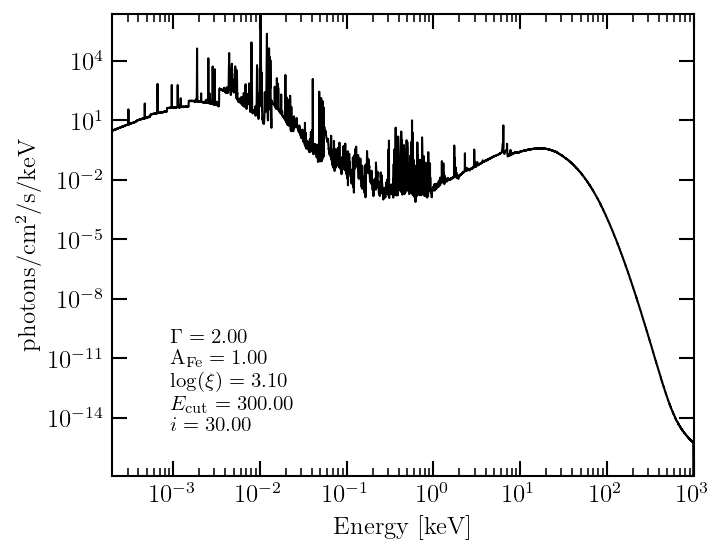

In [37]:
# Asia's figure configuration of choice


plotting.configure_plots()

fig, ax = plt.subplots()
ax.loglog(egrid, spec, c="k")

ax.set_xlabel("Energy [keV]")
ax.set_ylabel(r"$\rm photons / cm^2 / s / keV$")
ax.set_xlim(2e-4, 1e3)
ax.set_ylim(0.98 * spec.min(), 1.1 * spec.max())

gamma, Afe, logxi, Ecut, Incl = 2.0, 1.0, 3.1, 300, 30
pars = (
    r"$\Gamma=%.2f$" % gamma
    + "\n"
    + r"$\rm A_{Fe}=%.2f$" % Afe
    + "\n"
    + r"$\log(\xi)=%.2f$" % logxi
    + "\n"
    + r"$E_{\rm cut}=%.2f$" % Ecut
    + "\n"
    + r"$i=%.2f$" % Incl
)
ax.text(0.1, 0.1, pars, transform=ax.transAxes, fontsize=10)

### Make a prediction for an arbitrary set of input parameters 

In [5]:
gamma = 2.5
Afe = 5.0
logxi = 3.0
Ecut = 200.0
Incl = 60.0

egrid, spec2 = emullver.emulated_spectrum(
    gamma=gamma, Afe=Afe, logxi=logxi, Ecut=Ecut, Incl=Incl, emulator=emulator
)

1/1 [==============================] - 0s 21ms/step


Text(0.1, 0.1, '$\\Gamma=2.50$\n$\\rm A_{Fe}=5.00$\n$\\log(\\xi)=3.00$\n$E_{\\rm cut}=200.00$\n$i=60.00$')

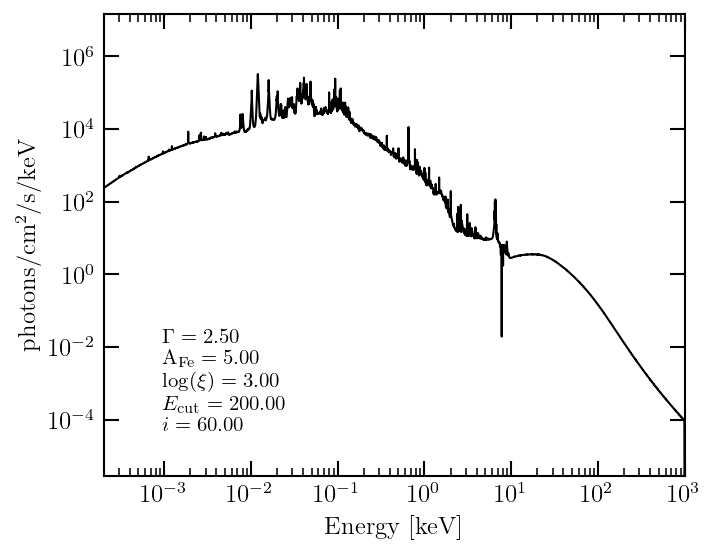

In [6]:
fig, ax = plt.subplots()
ax.loglog(egrid, spec2, c="k")

ax.set_xlabel("Energy [keV]")
ax.set_ylabel(r"$\rm photons / cm^2 / s / keV$")
ax.set_xlim(2e-4, 1e3)
ax.set_ylim(0.98 * spec2.min(), 1.1 * spec2.max())

pars = (
    r"$\Gamma=%.2f$" % gamma
    + "\n"
    + r"$\rm A_{Fe}=%.2f$" % Afe
    + "\n"
    + r"$\log(\xi)=%.2f$" % logxi
    + "\n"
    + r"$E_{\rm cut}=%.2f$" % Ecut
    + "\n"
    + r"$i=%.2f$" % Incl
)
ax.text(0.1, 0.1, pars, transform=ax.transAxes, fontsize=10)

------
# Comparison with XSPEC 
### requires a choice of a xillver table and initialising HEASOFT


An example comparison with the parameter set defined above

In [1]:
gamma = 2 #1-3.4
Afe = 8 #0.5-10
logxi = 3 #0-4.69897
Ecut = 999.0 #20-1000
Incl = 50 #18.1949 - 87.134

from emullver import params_to_physical_units
from xspec_comparison import compare_spectra

2024-08-26 12:11:37.707487: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-26 12:11:37.712031: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-26 12:11:37.771770: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-26 12:11:37.771825: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-26 12:11:37.773512: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [ ]:
with open("data.pickle", "rb") as handle:
    data = pickle.load(handle)

In [ ]:
train_x = np.array(data['train_x']).reshape(62400, 5)
train_y = np.array(data['train_y']).reshape(62400, 4999)

In [ ]:
from xspec import *

Xset.chatter = 0
Xset.logChatter = 0